In [7]:
import numpy as np
from distance import *
from MCMC import * 
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.neighbors import KernelDensity

def plot_contours(X,Y,Z,cmap='Grays',xi2_levels=np.array([11.829,6.1801,2.2977,0]),label=r"$\mathrm{Pantheon}$"):
    
    levels = np.max(Z) - xi2_levels/2
    i,j = np.unravel_index(np.argmax(Z), np.array(Z).shape)
    
    pl.figure(figsize=(10,10))
    pl.contourf(X,Y,Z,levels=levels,alpha=.3,cmap='Reds')
    pl.plot([0,1],[1,0],linestyle='--',c='k')
    pl.plot([0,1],[0,0.5],linestyle='--',c='k')
    pl.xlabel(r'$\Omega_m$',size=25)
    pl.ylabel(r'$\Omega_\Lambda$',size=25)
    pl.text(X[i,j]+0.1,Y[i,j]+0.1,s=label,rotation=45,fontsize=15,color='r')
    pl.text(0.38,0.38,s='Flat universe',rotation=-45,fontsize=20,color='k')
    pl.text(0.2,0.12,s='Expanding universe',rotation=np.arctan(0.5)*360/(2*np.pi),fontsize=20,color='k')
    
    pl.title('oCDM Constrains For SN-only Sample.',size=20)
    pl.xlim(0,1)
    pl.ylim(0,1)

- Data: $X_i \equiv (\mu_i, z_i)$

- Cosmological parameters: ${\Omega} = {\Omega_{\Lambda}, \Omega_{m}, \Omega_{k}}$

- Likelihood: $$P( \vec X| \Omega_m, \Omega_{\Lambda}, \Omega_k) \propto \exp \left( -\frac{1}{2}\Delta \vec \mu \cdot C^{-1} \cdot \Delta \vec \mu\right)$$

where
$\Delta  \mu_{i} = \mu_{i} -  \mu_{model}(z_i; \Omega)$

# Loading data


In [8]:
data=pd.read_csv('lcparam_DS17f.txt',delimiter=' ')
cov_data = np.array(pd.read_csv('sys_DS17f.txt'))

# create numpy version data
red_shift_data = (data['zcmb']).to_numpy()
apparent_magnitude_data = (data['mb']).to_numpy() 
apparent_magnitude_standard_errors = (data['dmb']).to_numpy()
stat_cov = np.diag(apparent_magnitude_standard_errors**2.)
sys_cov = cov_data.reshape(40, 40)
cov_matrix = stat_cov + sys_cov

inv_cov=  np.linalg.inv(cov_matrix)





# Plotting Covariance


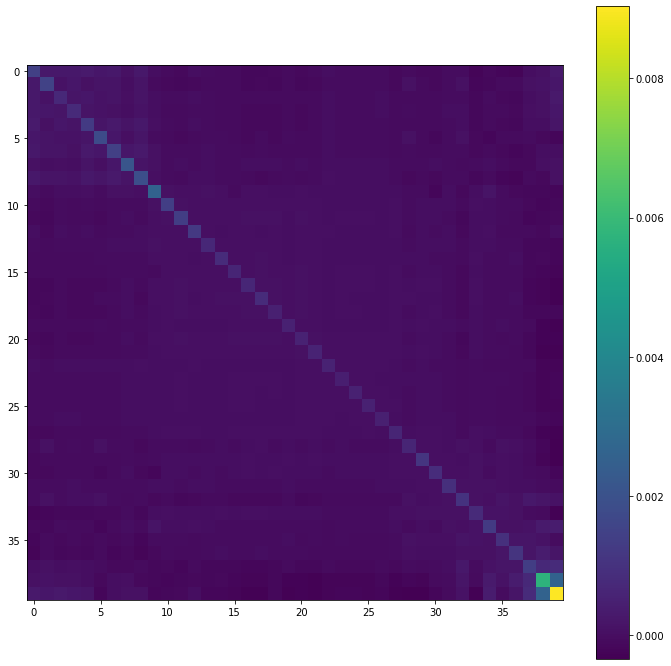

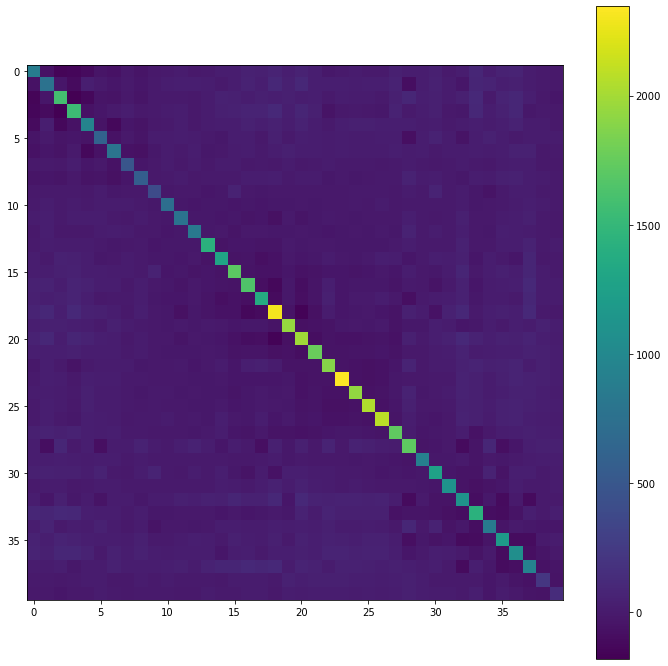

In [9]:
pl.figure(figsize=(12,12))
pl.imshow(cov_matrix)
pl.colorbar()

pl.figure(figsize=(12,12))
pl.imshow(inv_cov)
pl.colorbar()


# Test distance modulus


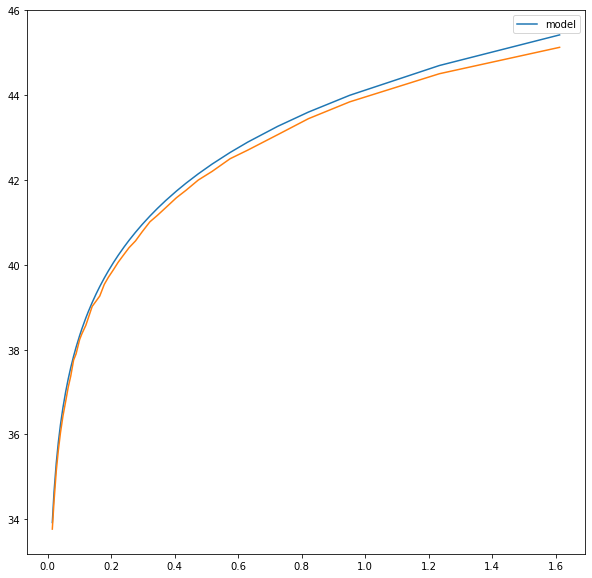

In [10]:

mu_model = distance_modulus(red_shift_data,.286,.714,69.6,1E2)
M = -19.2

pl.figure(figsize=(10,10))
pl.plot(red_shift_data,mu_model,label='model')
pl.plot(red_shift_data,apparent_magnitude_data-M)
pl.legend()

In [32]:
pars_label = [r'$\Omega_m$',r'$\Omega_{\Lambda}$',r'$H_0$']
nwalkers = 10
cov_gen = np.diag([0.1**2.,0.1**2.,5**2.])
chains = []
for n in range(nwalkers):
    
#     Omegas = np.uniogenerator([0.3,0.7,70],cov_gen)
    Omegas = np.random.uniform(0,[1,1,100],3)
    
    chain = run_MCMC(red_shift_data,apparent_magnitude_data,cov_matrix,p0=Omegas,cov_gen=cov_gen,nsteps=10000)
    chains.append(chain)
    
stacked_chain = np.vstack(np.array(chains))

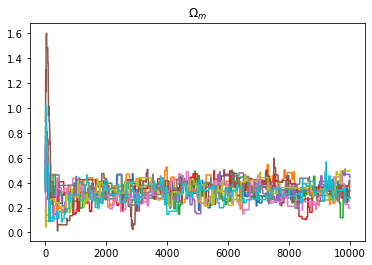

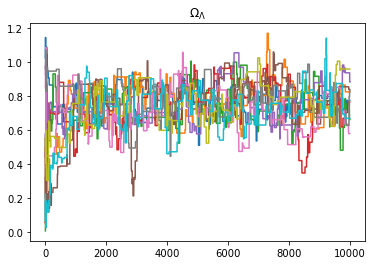

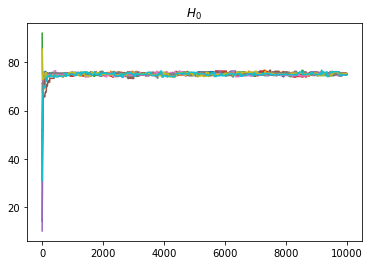

In [33]:
    
for i in range(chain.shape[1]):
    pl.figure()
    
    for chain in chains:
        c = chain[:,i]
        n = range(chain.shape[0])
        pl.plot(n,c)

    pl.title(pars_label[i])
    

<ipython-input-34-a9407917b10d>:4: RuntimeWarning: divide by zero encountered in log
  H = np.log(H.T/H.sum())


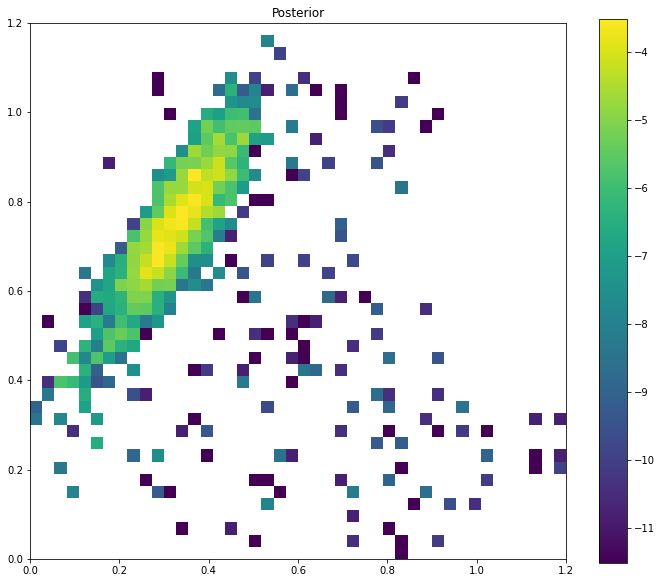

In [34]:
x,y = stacked_chain[:,0],stacked_chain[:,1]
edges = np.linspace(0,1.2,45)
H, xedges, yedges = np.histogram2d(x, y,bins=(edges,edges))
H = np.log(H.T/H.sum())


fig = pl.figure(figsize=(12, 10))

ax = fig.add_subplot(111, title='Posterior')

pl.imshow(H, interpolation='nearest', origin='lower',

        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

pl.colorbar()

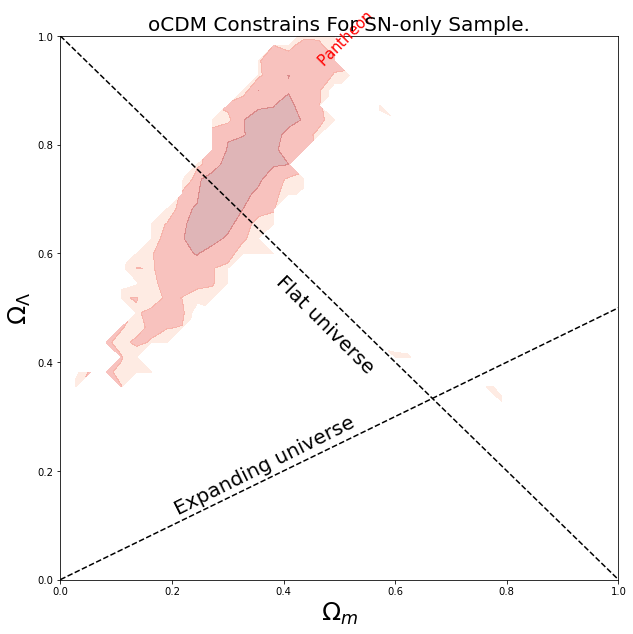

In [35]:
X, Y = np.meshgrid(edges[0:-1],edges[0:-1])
plot_contours(X,Y,H)


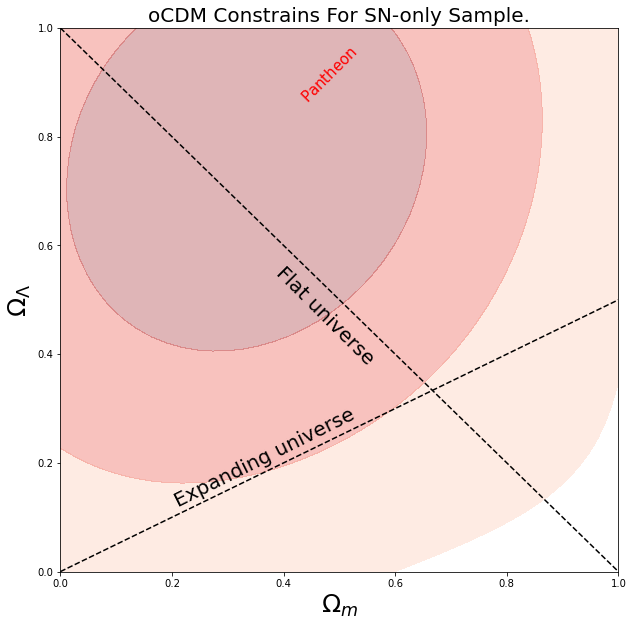

In [36]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.vstack([y, x]).T)
xy = np.vstack([Y.ravel(), X.ravel()]).T

z = kde.score_samples(xy)
Z = np.reshape(z, X.shape)
plot_contours(X,Y,Z)


In [24]:
stacked_chain[:,0:2]

array([[0.28614767, 0.25252872],
       [0.28614767, 0.25252872],
       [0.28614767, 0.25252872],
       ...,
       [0.21927574, 0.57808014],
       [0.21927574, 0.57808014],
       [0.21927574, 0.57808014]])